In [1]:
import torch

print(torch.__version__)

2.2.0+cu121


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
sns.set(style='ticks', palette='Set2')
sns.despine()
sns.set_context("talk")

/tmp/ipykernel_254533/2045451853.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/varun/LPGNN/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [2]:
def confidence_interval(data, func=np.mean, size=1000, ci=95, seed=12345):
    bs_replicates = sns.algorithms.bootstrap(data, func=func, n_boot=size, seed=seed)
    bounds = sns.utils.ci(bs_replicates, ci)
    return (bounds[1] - bounds[0]) / 2

In [3]:
def sort_key(row):
    keys = {
        'cora': 1, 'pubmed': 2, 'facebook': 3, 'lastfm': 4,     # datasets
        'gcn': 1, 'gat': 2, 'sage': 3,                          # models
        'rnd': 1, '1rnd': 2, 'one': 3, 'ohd': 4, 'raw': 5,      # features
        'mbm': 6, '1bm': 2, 'rbm': 3, 'lpm': 4, 'agm': 5,       # mechanism
    }
    return row.replace(keys)


def aggregate_results():
    list_csv = [os.path.join('results/', file) for file in os.listdir('results/') if file.endswith('.csv')]
    columns = ['Name', 'dataset', 'model', 'feature', 'mechanism', 'x_eps', 'y_eps', 'x_steps', 'y_steps', 
               'forward_correction', 'test/acc']
    df = pd.DataFrame()

    for csv_file in tqdm(list_csv):
        df_csv = pd.read_csv(
            csv_file,
            usecols=columns,
        )
#         df = df.concat(df_csv, ignore_index=True)
        df = pd.concat([df, df_csv], ignore_index=True)

    df = df.groupby(list(set(columns) - set(['test/acc'])))[['test/acc']].agg(
        mean=('test/acc', 'mean'),
        ci=('test/acc', confidence_interval)
    ).reset_index().rename(
        columns=lambda name: f'test/acc_{name}' if name in ['mean', 'ci'] else name
    ).set_index('Name')

    df.to_csv('results/data.csv')
    return df

def read_logs(best_steps=False, **params):
    try:
        df = pd.read_csv('results/data.csv', index_col='Name')
    except FileNotFoundError:
        df = aggregate_results()
    
    if params:
        condition = True
        for param_name, param_val in params.items():
            if isinstance(param_val, list) or isinstance(param_val, tuple):
                condition &= df[param_name].isin(param_val)
            else:
                condition &= df[param_name] == param_val
        df = df[condition]
    
    if best_steps:
        df_steps = pd.read_csv('hparams/steps.csv')
        if 'x_steps' in params:
            df_steps = df_steps.drop(columns=['x_steps'])
        if 'y_steps' in params:
            df_steps = df_steps.drop(columns=['y_steps'])
        df = df.merge(df_steps, how='inner', on=df_steps.columns.to_list())
        
    return df.sort_values(['dataset', 'model', 'feature', 'mechanism', 'x_eps', 'y_eps', 'x_steps', 'y_steps'], key=sort_key)


def export_figure(path, df, x, y, hue=None, row=None, col=None, ci=95, prefix=''):
    if not os.path.exists(path):
        os.makedirs(path)

    tolist = lambda arg: [arg] if arg else []
    group = tolist(row) + tolist(col) + tolist(hue)

    if ci in df.columns:
        output = [x, y, ci]
    elif ci == 'sd':
        df = df.groupby(group + [x])[y].agg(['mean', np.std]).reset_index()
        output = [x, 'mean', 'std']
    else:
        df = df.groupby(group + [x]).agg(mean=(y, 'mean'),
                                           std=(y, lambda a: confidence_interval(a, ci=ci))).reset_index()
        output = [x, 'mean', 'std']
    
    df['filename'] = df[group].apply(
        lambda record: ','.join(
            ([prefix] if prefix else []) + [f'{key}={val}' for key, val in record.items()]  # + [f'x={x}', f'y={y}']
        ) + '.csv', axis=1
    )
    df.groupby('filename').apply(
        lambda record: record[output].to_csv(
            os.path.join(path, record['filename'].unique().item()),
            index=None,
            sep=','
        )
    )

# Performance of LPGNN under varying privacy budgets

/tmp/ipykernel_254533/3625756386.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return row.replace(keys)
/home/varun/LPGNN/myenv/lib/python3.10/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/tmp/ipykernel_254533/2409442237.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(
/home/varun/LPGNN/myenv/lib/python3.10/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/tmp/ipykernel_254533/2409442237.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  

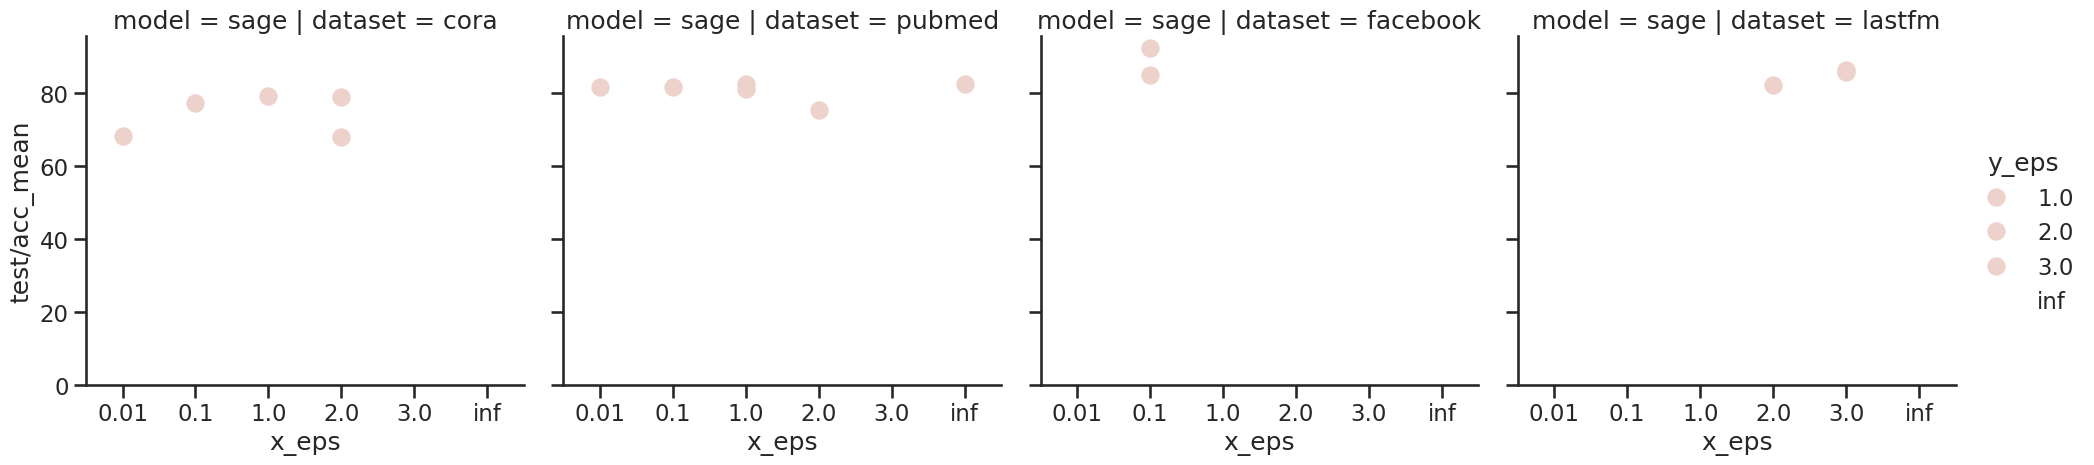

In [4]:
df = read_logs(
    model=['gcn', 'gat','sage'], 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01,0.1,1,2,3, np.inf], 
    y_eps=[1,2,3,np.inf], 
    forward_correction=True,
    best_steps=True
)

ax = sns.catplot(
    kind='point', data=df, x='x_eps', y='test/acc_mean', hue='y_eps', col='dataset', row='model', ci=None,
    sharex=True, sharey=True, join=False
)
ax.set(ylim=0)

export_figure(path='figures/xyeps', df=df, x='x_eps', y='test/acc_mean', hue='y_eps', 
              row='model', col='dataset', ci='test/acc_ci')

# Comparison of LPGNN against baselines with ad-hoc features

In [5]:
df = read_logs(
    model='sage', 
    feature=['raw', 'rnd', 'one', 'ohd'], 
    mechanism='mbm',
    x_eps=[0.01, 0.1, 1,np.inf], 
    y_eps=[1],
    forward_correction=True,
    best_steps=True
)

df['test/acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.1f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)
df['method'] = df[['feature', 'x_eps']].apply(
    lambda row: row['feature'] + (f"($\epsilon_x=${row['x_eps']})" if not np.isinf(row['x_eps']) else ''), axis=1
)
df = df.pivot(index='dataset', columns=['method'], values=['test/acc']).T.droplevel(0).iloc[:,[0,3,1,2]]
df

/tmp/ipykernel_254533/3625756386.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return row.replace(keys)


IndexError: positional indexers are out-of-bounds

# Comparison of MBM against relevant mechanisms

In [6]:
df = read_logs(
    model='sage', 
    feature=['raw'], 
    mechanism=['mbm', '1bm', 'lpm', 'agm'],
    x_eps=[0.01,0.1,1,2], 
    y_eps=[np.inf],
    forward_correction=True,
    best_steps=True
)
df['test/acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.1f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)
df = df.pivot(columns='x_eps', index=['dataset', 'mechanism'], values='test/acc').reset_index().sort_values(
    by=['dataset', 'mechanism'],
    key=sort_key
).set_index(['dataset', 'mechanism'])
df

/tmp/ipykernel_254533/3625756386.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return row.replace(keys)
/tmp/ipykernel_254533/3625756386.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return row.replace(keys)


,x_eps,0.01,0.1,1.0
dataset,mechanism,,,
cora,mbm,71.0 $\pm$ 2.3,65.8 $\pm$ 3.0,NaN
pubmed,mbm,78.0 $\pm$ 0.7,NaN,82.9 $\pm$ 0.1
facebook,mbm,85.2 $\pm$ 0.7,91.1 $\pm$ 0.4,NaN
lastfm,mbm,NaN,NaN,85.0 $\pm$ 0.5


# Effect of KProp on LPGNN's performance

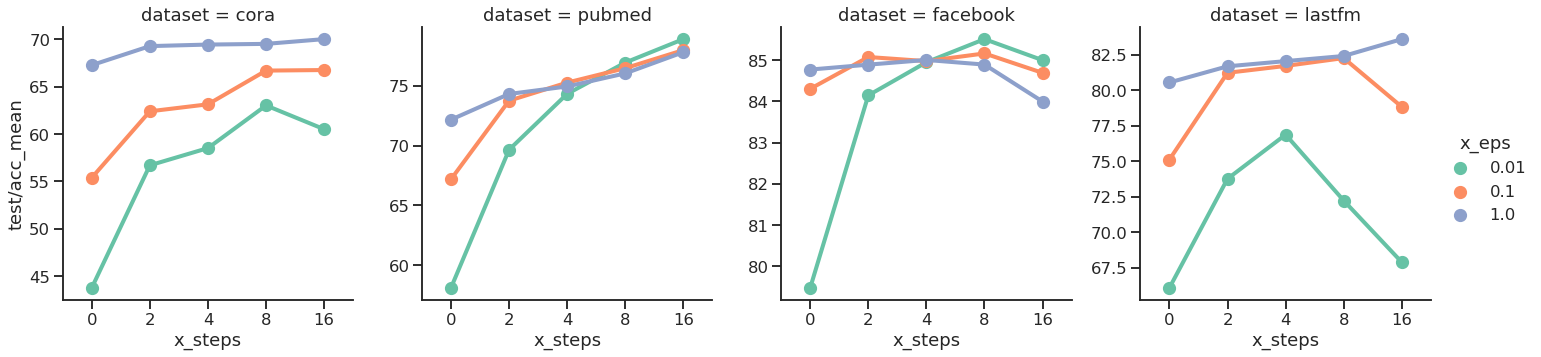

In [7]:
df = read_logs(
    model='sage', 
    feature='raw', 
    mechanism='mbm', 
    x_eps=[0.01, 0.1, 1], 
    x_steps=[0, 2, 4, 8, 16],
    y_eps=1, 
    #y_steps=0,
    forward_correction=True,
    best_steps=True
)

ax = sns.catplot(
    kind='point', data=df, x='x_steps', y='test/acc_mean', hue='x_eps', col='dataset', #ci=None,
    sharex=True, sharey=False, join=True
)

# ax.set(ylim=(40,90))

export_figure(path='figures/kprop', df=df, x='x_steps', y='test/acc_mean', hue='x_eps', 
              col='dataset', ci='test/acc_ci')

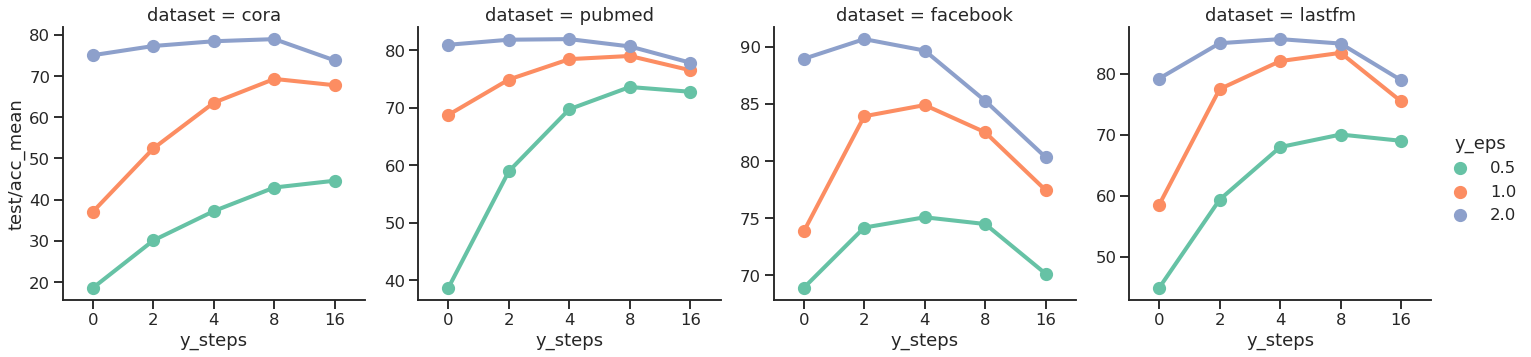

In [8]:
df = read_logs(
    model='sage', 
    feature='raw', 
    mechanism='mbm', 
    y_eps=[0.5,1,2], 
    y_steps=[0, 2, 4, 8, 16],
    x_eps=1, 
    #x_steps=4,
    forward_correction=True,
    best_steps=True
)

ax = sns.catplot(
    kind='point', data=df, x='y_steps', y='test/acc_mean', hue='y_eps', col='dataset', ci=None,
    sharex=True, sharey=False, join=True
)

export_figure(path='figures/kprop', df=df, x='y_steps', y='test/acc_mean', hue='y_eps', 
              col='dataset', ci='test/acc_ci')

# Effect of label denoising

In [9]:
x_eps = 1
y_eps = [0.5, 1, 2]

df_ce = read_logs(
    model='sage', 
    feature='raw', 
    mechanism='mbm', 
    y_eps=y_eps, 
    y_steps=0,
    x_eps=x_eps,
    forward_correction=False,
    best_steps=True
)
df_ce['method'] = 'cross-entropy'

df_fc = read_logs(
    model='sage', 
    feature='raw', 
    mechanism='mbm', 
    y_eps=y_eps, 
    y_steps=0,
    x_eps=x_eps,
    forward_correction=True,
    best_steps=True
)
df_fc['method'] = 'forward correction'

df_us = read_logs(
    model='sage', 
    feature='raw', 
    mechanism='mbm', 
    y_eps=y_eps, 
    x_eps=x_eps,
    forward_correction=True,
    best_steps=True
)
df_us['method'] = 'DROP'

df = df_ce.append(df_fc, ignore_index=True).append(df_us, ignore_index=True)
df['test/acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.1f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1)
df = df.pivot(index='method', columns=['dataset', 'y_eps'], values='test/acc').T.iloc[:,[1,2,0]]
df

method           cross-entropy forward correction            DROP
dataset  y_eps                                                   
cora     0.5    18.6 $\pm$ 1.3     18.6 $\pm$ 2.5  42.9 $\pm$ 1.5
         1.0    25.5 $\pm$ 1.7     37.1 $\pm$ 2.5  69.3 $\pm$ 1.2
         2.0    52.9 $\pm$ 2.1     75.1 $\pm$ 1.0  78.4 $\pm$ 0.7
pubmed   0.5    37.1 $\pm$ 0.9     38.7 $\pm$ 1.4  69.8 $\pm$ 0.7
         1.0    65.4 $\pm$ 0.6     68.8 $\pm$ 0.7  74.9 $\pm$ 0.3
         2.0    80.5 $\pm$ 0.2     81.0 $\pm$ 0.2  81.0 $\pm$ 0.2
facebook 0.5    50.9 $\pm$ 4.2     68.9 $\pm$ 1.3  75.1 $\pm$ 0.6
         1.0    55.2 $\pm$ 1.3     73.8 $\pm$ 1.1  84.9 $\pm$ 0.2
         2.0    81.6 $\pm$ 1.2     88.9 $\pm$ 0.2  90.7 $\pm$ 0.1
lastfm   0.5    21.1 $\pm$ 4.6     44.9 $\pm$ 5.3  70.0 $\pm$ 3.0
         1.0    28.4 $\pm$ 2.5     58.5 $\pm$ 3.6  82.1 $\pm$ 1.0
         2.0    56.8 $\pm$ 2.8     79.2 $\pm$ 1.3  85.7 $\pm$ 0.7